# 03a Validate CATE estimators GI

In this notebook, we will try to validate CATE estimators with respect to the GI outcome.

### Contents:
1. Set up
2. Calibration and R2  
2.1. Calibration plots for a fixed data split  
2.2. CR2 generalization scatter plots  
2.3. Aggregate R2 statistics. 
3. Monotonicity  
3.1. Monotinicity with respect to 5 bins  
3.2. Comparing quantile-based top subgroup with its complement  
4. Stability of CATE estimators  
4.1. Stability of quantile-based top subgroup  
4.2. Overlaps of quantile-based subgroups  
4.3. Aggregate correlation statistics  
4.4. Pairwise correlation for a single estimator when trained on different splits

## 1. Set up

In [3]:
# Standard imports
import numpy as np
import pandas as pd
from scipy import stats
import os
import copy
import random
import joblib

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import pylab

# Import sklearn methods
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Import own methods
from methods.data_processing import prepare_df, separate_vars
from methods.cate_estimator_validation import \
            (make_estimator_library, fit_estimator_libraries, 
             get_calibration_plot_data, get_cr2_plot_data, 
             get_calibration_score, get_cr2_score, get_r_values, 
             get_overlap_values, get_monotonicity_results, 
             combine_estimator_versions, get_top_subgroup_stability)

In [4]:
n_splits = 4
q_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

base_learners = {"lasso" : Lasso(),
                 "logistic" : LogisticRegression(solver = "liblinear", 
                                                 max_iter = 500),
                 "rf" : RandomForestRegressor(),
                 "xgb" : XGBRegressor(objective = "reg:squarederror")}

outcome = 'fausebal'
dir_neg = False
n_bins = 5

In [5]:
# Global plot style settings
plt.style.use("fivethirtyeight")
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

label_size = 25
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

# Save settings
SAVE_PATH  = f"figs/{outcome}/"
savfig = True

In [7]:
# Prefer imputed dataset from 02 (no recomputation)
from pathlib import Path
import pickle

IMPUTATION_META = Path(f"output/params/{outcome}/analysis_imputation_meta.pkl")

if IMPUTATION_META.exists():
    with open(IMPUTATION_META, 'rb') as f:
        _meta = pickle.load(f)
    # Determine treatment and outcome
    treatment = _meta.get("treatment_var", "message_fa")
    outcomes = _meta.get("outcomes", [])
    # Determine features
    features = _meta.get("features", None)
    print("✓ Loaded metadata from 02")
else:
    print("Dataset from 02 not found; using locally computed features/imputation.")


✓ Loaded metadata from 02


### 1.1. Fit estimators in the library

In [10]:
import warnings
warnings.filterwarnings("ignore")
# Load tuned params (now consolidated into a single file holding all splits)
MODEL_CSV = Path("output/analysis/")
tuned_params = joblib.load(f"output/params/{outcome}/{outcome}_tuned_params.pkl")

try:
    fitted_libraries = joblib.load(f"output/analysis/{outcome}/{outcome}_fitted_libraries.pkl")
except:
    fitted_libraries = fit_estimator_libraries(MODEL_CSV, features, outcome, 
                                            base_learners, tuned_params, n_splits, 
                                            perturbed = True, num_cv_splits = 2)
    # Dump the fitted libraries
    joblib.dump(fitted_libraries, f"output/analysis/{outcome}/{outcome}_fitted_libraries.pkl")

100%|██████████| 23/23 [14:45<00:00, 38.50s/it] 


## 2. Calibration and R2 (predictability)

### 2.1. Calibration plots for a fixed data split

In [11]:
# Settings
selected_estimators = ["s_rf", "t_rf", "x_rf", "r_rfrf", "causal_forest_1"]
new_labels = ["S_RF", "T_RF", "X_RF","R_RFRF", "CF_1"]
new_labels_dict = dict(zip(selected_estimators, new_labels))

fold_no = 0

In [12]:
# Get data to make plot
try:
    cal_plot_data = joblib.load(f"output/analysis/{outcome}/{outcome}_calplotdata.pkl")
except:
    val_plots_data = {}
    train_plots_data = {}
    for estimator in selected_estimators:
        val_plots_data[estimator] = get_calibration_plot_data( \
                            fitted_libraries["pert_none"][estimator], fold_no, n_bins)
        train_plots_data[estimator] = get_calibration_plot_data( \
                            fitted_libraries["pert_none"][estimator], 
                            fold_no, n_bins, kind = "train")
    cal_plot_data = [train_plots_data, val_plots_data]
    joblib.dump(cal_plot_data, f"output/analysis/{outcome}/{outcome}_calplotdata.pkl")

In [13]:
from methods.causal_functions import get_Neyman_ATE
df = pd.read_csv(os.path.join(MODEL_CSV, outcome, "trainval_data.csv"))
ATE = get_Neyman_ATE(df[outcome], df['TREATED'])
print(f"Average Treatment Effect (ATE): {ATE:.4f}")

Average Treatment Effect (ATE): -0.0101


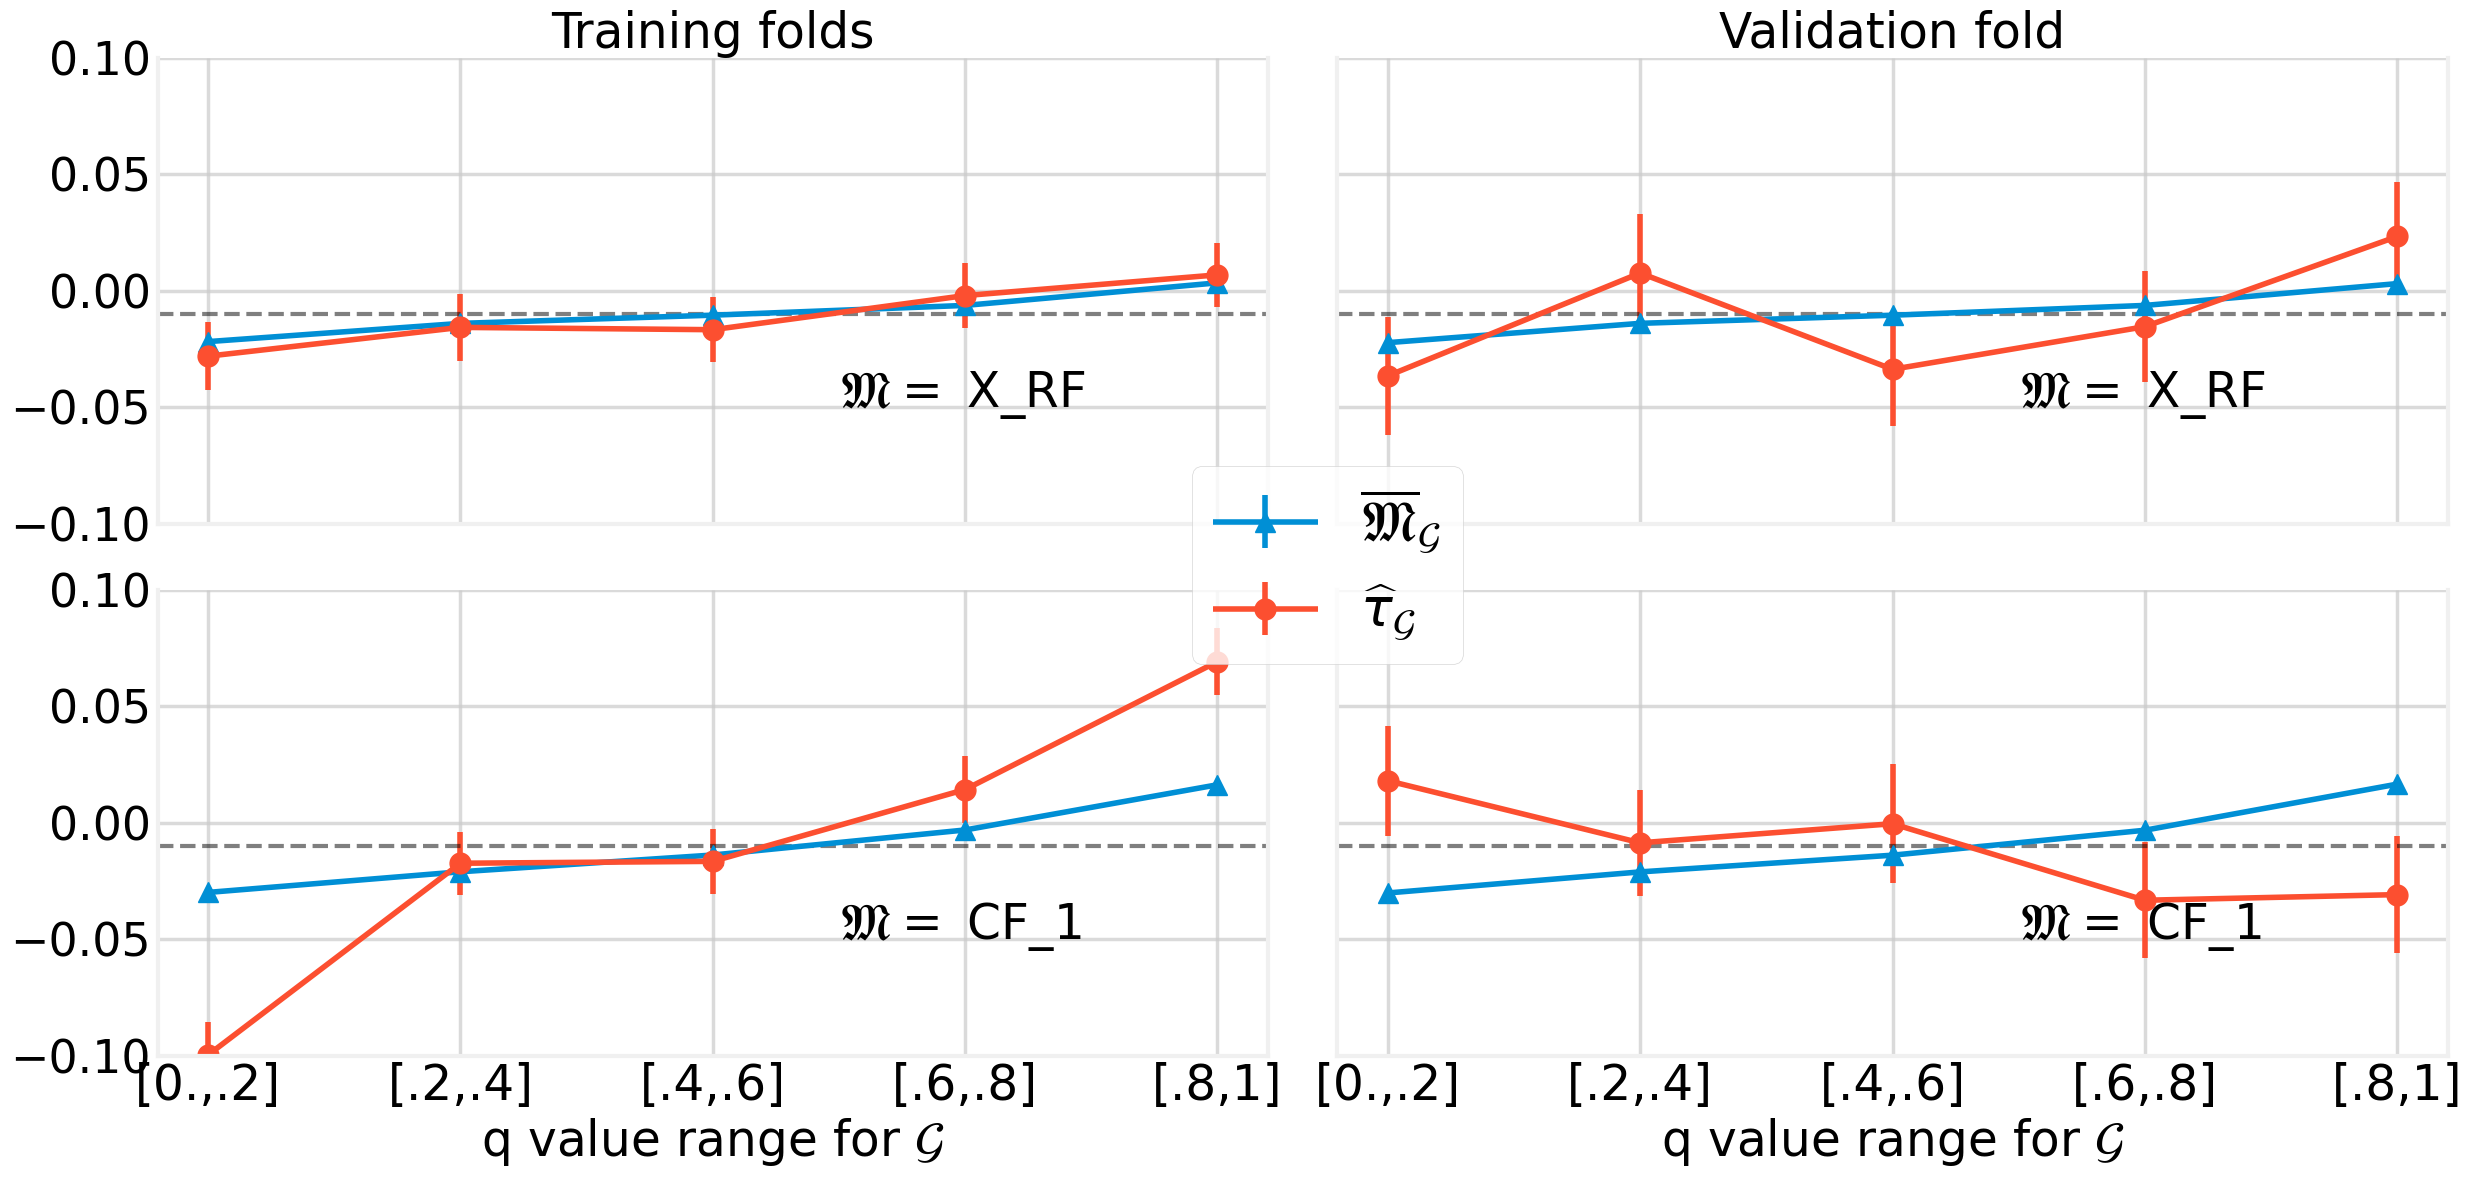

In [14]:
label_size = 35
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = 33
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

xticks = ['[0.,.2]', '[.2,.4]', '[.4,.6]', '[.6,.8]', '[.8,1]']
fig, axes = plt.subplots(2, 2, sharey = True, sharex=True, figsize = [25, 12])
axes = axes.flatten()
for j, estimator in enumerate(['x_rf', 'causal_forest_1']):
    ax1, ax2 = axes[2*j], axes[2*j+1]
    for k, (lab, title, ax) in enumerate(zip(["train", "val"], 
                                             ["Training folds", "Validation fold"], 
                                             [ax1 ,ax2])):
        if j == 0:
            ax.set_title(title)
        # Plot model CATEs
        p1 = ax.errorbar(x = np.arange(0, n_bins), 
                    y = cal_plot_data[k][estimator]["model_CATEs"], 
                    yerr = cal_plot_data[k][estimator]["model_CATEs_std"],
                    marker= '^', markersize = 15, #color = "red",
                    linewidth = 4., 
                    label = r'$\overline{\mathfrak{M}}_{\mathcal {G}}$')
        # Plot Neyman CATEs
        p2 = ax.errorbar(x = np.arange(0, n_bins), 
                    y = cal_plot_data[k][estimator]["Neyman_CATEs"],
                    yerr = cal_plot_data[k][estimator]["Neyman_CATEs_std"],
                    marker = 'o', markersize = 15, #color = "blue",
                    linewidth = 4., 
                    label = r'$\widehat{\tau}_{\mathcal{G}}$')
        ax.text(x=2.5, y=-0.05, s= r'$\mathfrak{M}=$ ' + new_labels_dict[estimator], 
                fontsize=label_size)
        # Add line to indicate ATE
        ax.axhline(y = ATE, linestyle='--', color = 'k', linewidth = 3., alpha = 0.5)
        ax.set_ylim([-0.1, 0.1])
        # X labels and legend
        if j == 1:
            ax.set_xticks(np.arange(0, n_bins))
#             ax.set_xticklabels(cal_plot_data[k][estimator].index)
            ax.set_xticklabels(xticks)
            ax.set_xlabel(r"q value range for $\mathcal{G}$")
#         if j == 0:
#             if k == 0:
#                 ax.legend(fontsize = 45)
            
        ax.grid(True, alpha = 0.7)
#         ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
# plt.suptitle("TC Events", y=1.01)
plt.tight_layout()
# Add legend
leg = fig.legend((p1, p2), (r'$\overline{\mathfrak{M}}_{\mathcal {G}}$', 
                            r'$\widehat{\tau}_{\mathcal{G}}$'), 
                 loc='center right', bbox_to_anchor=(0.6, 0.52), 
                 fontsize=38, frameon=True)

if savfig:
    plt.savefig(SAVE_PATH + f"{outcome}_x_rf_s_rf_calibration_plot.pdf",
                bbox_inches='tight')
# leg.remove()
# if savfig:
#     plt.savefig(SAVE_PATH + f"{outcome_name}_x_rf_s_rf_calibration_plot_no_leg.pdf"
#                 , bbox_inches='tight')
# plt.show()

### 2.2. CR2 generalization scatter plots

In [15]:
# Get data to make plot
try:
    cr2_5r_plot_data, cr2_2r_plot_data = joblib.load(f"output/analysis/{outcome}/{outcome}_rscores.pkl")
except:
    cr2_5r_plot_data = {}
    for estimator in selected_estimators:
        cr2_5r_plot_data[estimator] = \
                get_cr2_plot_data(fitted_libraries["pert_none"][estimator],
                                n_bins, n_bins_selected = n_bins,
                                dir_neg = dir_neg)

    cr2_2r_plot_data = {}
    for estimator in selected_estimators:
        cr2_2r_plot_data[estimator] = \
                get_cr2_plot_data(fitted_libraries["pert_none"][estimator], 
                                n_bins, n_bins_selected = 2, 
                                dir_neg = dir_neg)
    
    joblib.dump([cr2_5r_plot_data, cr2_2r_plot_data], f"output/analysis/{outcome}/{outcome}_rscores.pkl")

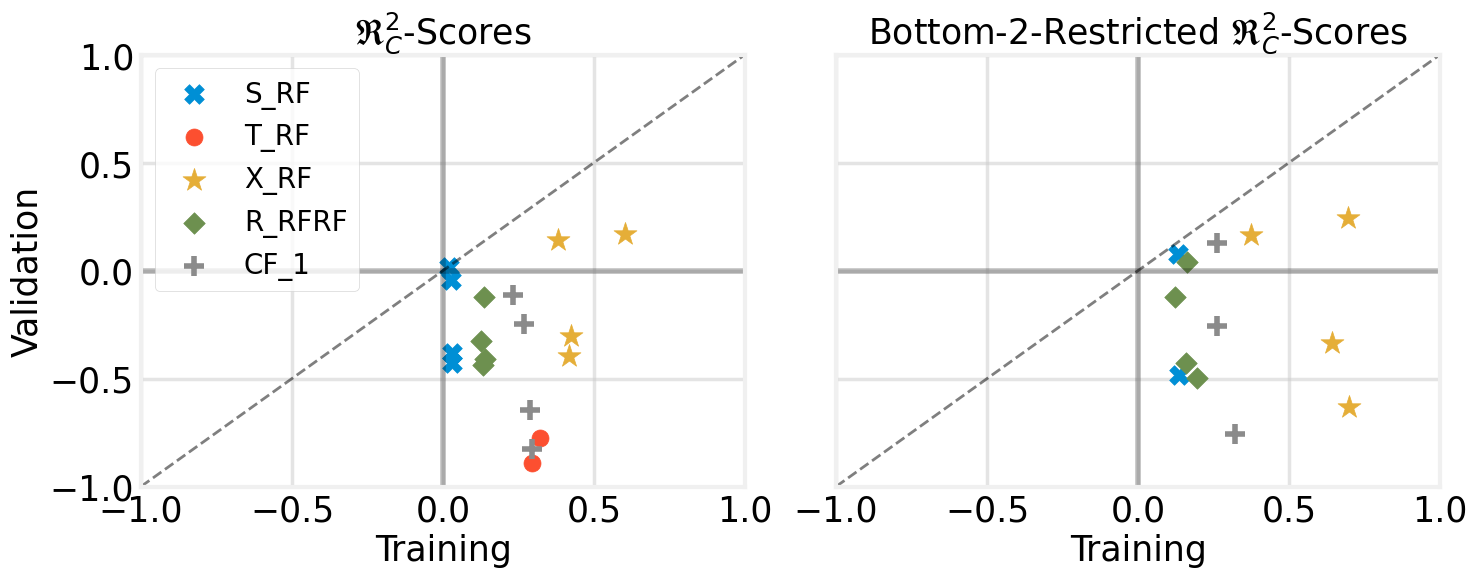

In [16]:
label_size = 25
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mss = ['X', 'o', '*', 'D', '+']
ms_size = [200, 150, 300, 120, 200]

f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, 
                             figsize = [15, 6])

for i, estimator in enumerate(selected_estimators):
    ax1.scatter(cr2_5r_plot_data[estimator]["cr2_train"], 
                cr2_5r_plot_data[estimator]["cr2_val"], 
                label = new_labels_dict[estimator], marker = mss[i], 
                s=ms_size[i])
ax1.plot([-1, 1], [-1, 1], 'k--', alpha = 0.5, linewidth = 2.)
ax1.axhline(y = 0, color = 'k', alpha = .25)
ax1.axvline(x = 0, color = 'k', alpha = .25)
ax1.set_ylabel("Validation")
ax1.set_xlabel("Training")
ax1.set_title(r"$\mathfrak{R}_C^2$-Scores")
ax1.grid(True, alpha = 0.5)
ax1.legend(loc="upper left")

for i, estimator in enumerate(selected_estimators):
    ax2.scatter(cr2_2r_plot_data[estimator]["cr2_train"], 
                cr2_2r_plot_data[estimator]["cr2_val"], 
                label = estimator, marker = mss[i], s=ms_size[i])
ax2.plot([-1, 1], [-1, 1], 'k--', alpha = 0.5, linewidth = 2.)
ax2.axhline(y = 0, color = 'k', alpha = .25)
ax2.axvline(x = 0, color = 'k', alpha = .25)
ax2.set_xlabel("Training")
ax2.set_title(r"Bottom-2-Restricted $\mathfrak{R}_C^2$-Scores")
ax2.grid(True, alpha = 0.5)

plt.ylim([-1, 1])
plt.xlim([-1, 1])
plt.tight_layout()

savfig = False
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome}_r2.pdf")
plt.show()

### 2.3. Aggregate R2 statistics

In [17]:
# Get data to make plot
all_estimators = list(fitted_libraries["pert_none"].keys())
try:
    cr2_plot_data = joblib.load(f"output/analysis/{outcome}/{outcome}_rscores_hist.pkl")
except:
    cr2_plot_data = {}
    for estimator in all_estimators:
        cr2_plot_data[estimator] = get_cr2_plot_data(fitted_libraries["pert_none"][estimator], 
                                                    n_bins, dir_neg=dir_neg)
        cr2_plot_data[estimator] = pd.concat([cr2_plot_data[estimator],
                                get_cr2_plot_data(fitted_libraries["pert_cv_0"][estimator], 
                                                n_bins, dir_neg=dir_neg)])
        cr2_plot_data[estimator] = pd.concat([cr2_plot_data[estimator],
                                get_cr2_plot_data(fitted_libraries["pert_cv_1"][estimator], 
                                                n_bins, dir_neg=dir_neg)])
        cr2_plot_data[estimator] = cr2_plot_data[estimator].reset_index() \
                                                        .drop(columns = ["index"])

    for estimator in all_estimators:
        cr2_plot_data[estimator] = cr2_plot_data[estimator].reset_index() \
                                                        .drop(columns = ["index"])

    joblib.dump(cr2_plot_data, f"output/analysis/{outcome}/{outcome}_rscores_hist.pkl")

all_cr2_scores_val = pd.concat(cr2_plot_data[estimator]["cr2_val"] 
                               for estimator in all_estimators)

all_cr2_scores_train = pd.concat(cr2_plot_data[estimator]["cr2_train"] 
                               for estimator in all_estimators)

In [18]:
get_cr2_plot_data(fitted_libraries["pert_none"]['x_lasso'], 5, dir_neg=dir_neg)

cr2_train   cr2_val
0   0.630161  0.460699
1   0.429956 -0.641485
2   0.560319 -0.606866
3   0.423316  0.271675

In [19]:
all_estimators = np.array(list(fitted_libraries["pert_none"].keys()))
estimator_argsort = np.argsort([-cr2_plot_data[estimator]["cr2_val"].mean() 
                                for estimator in all_estimators])
all_estimators = all_estimators[estimator_argsort]

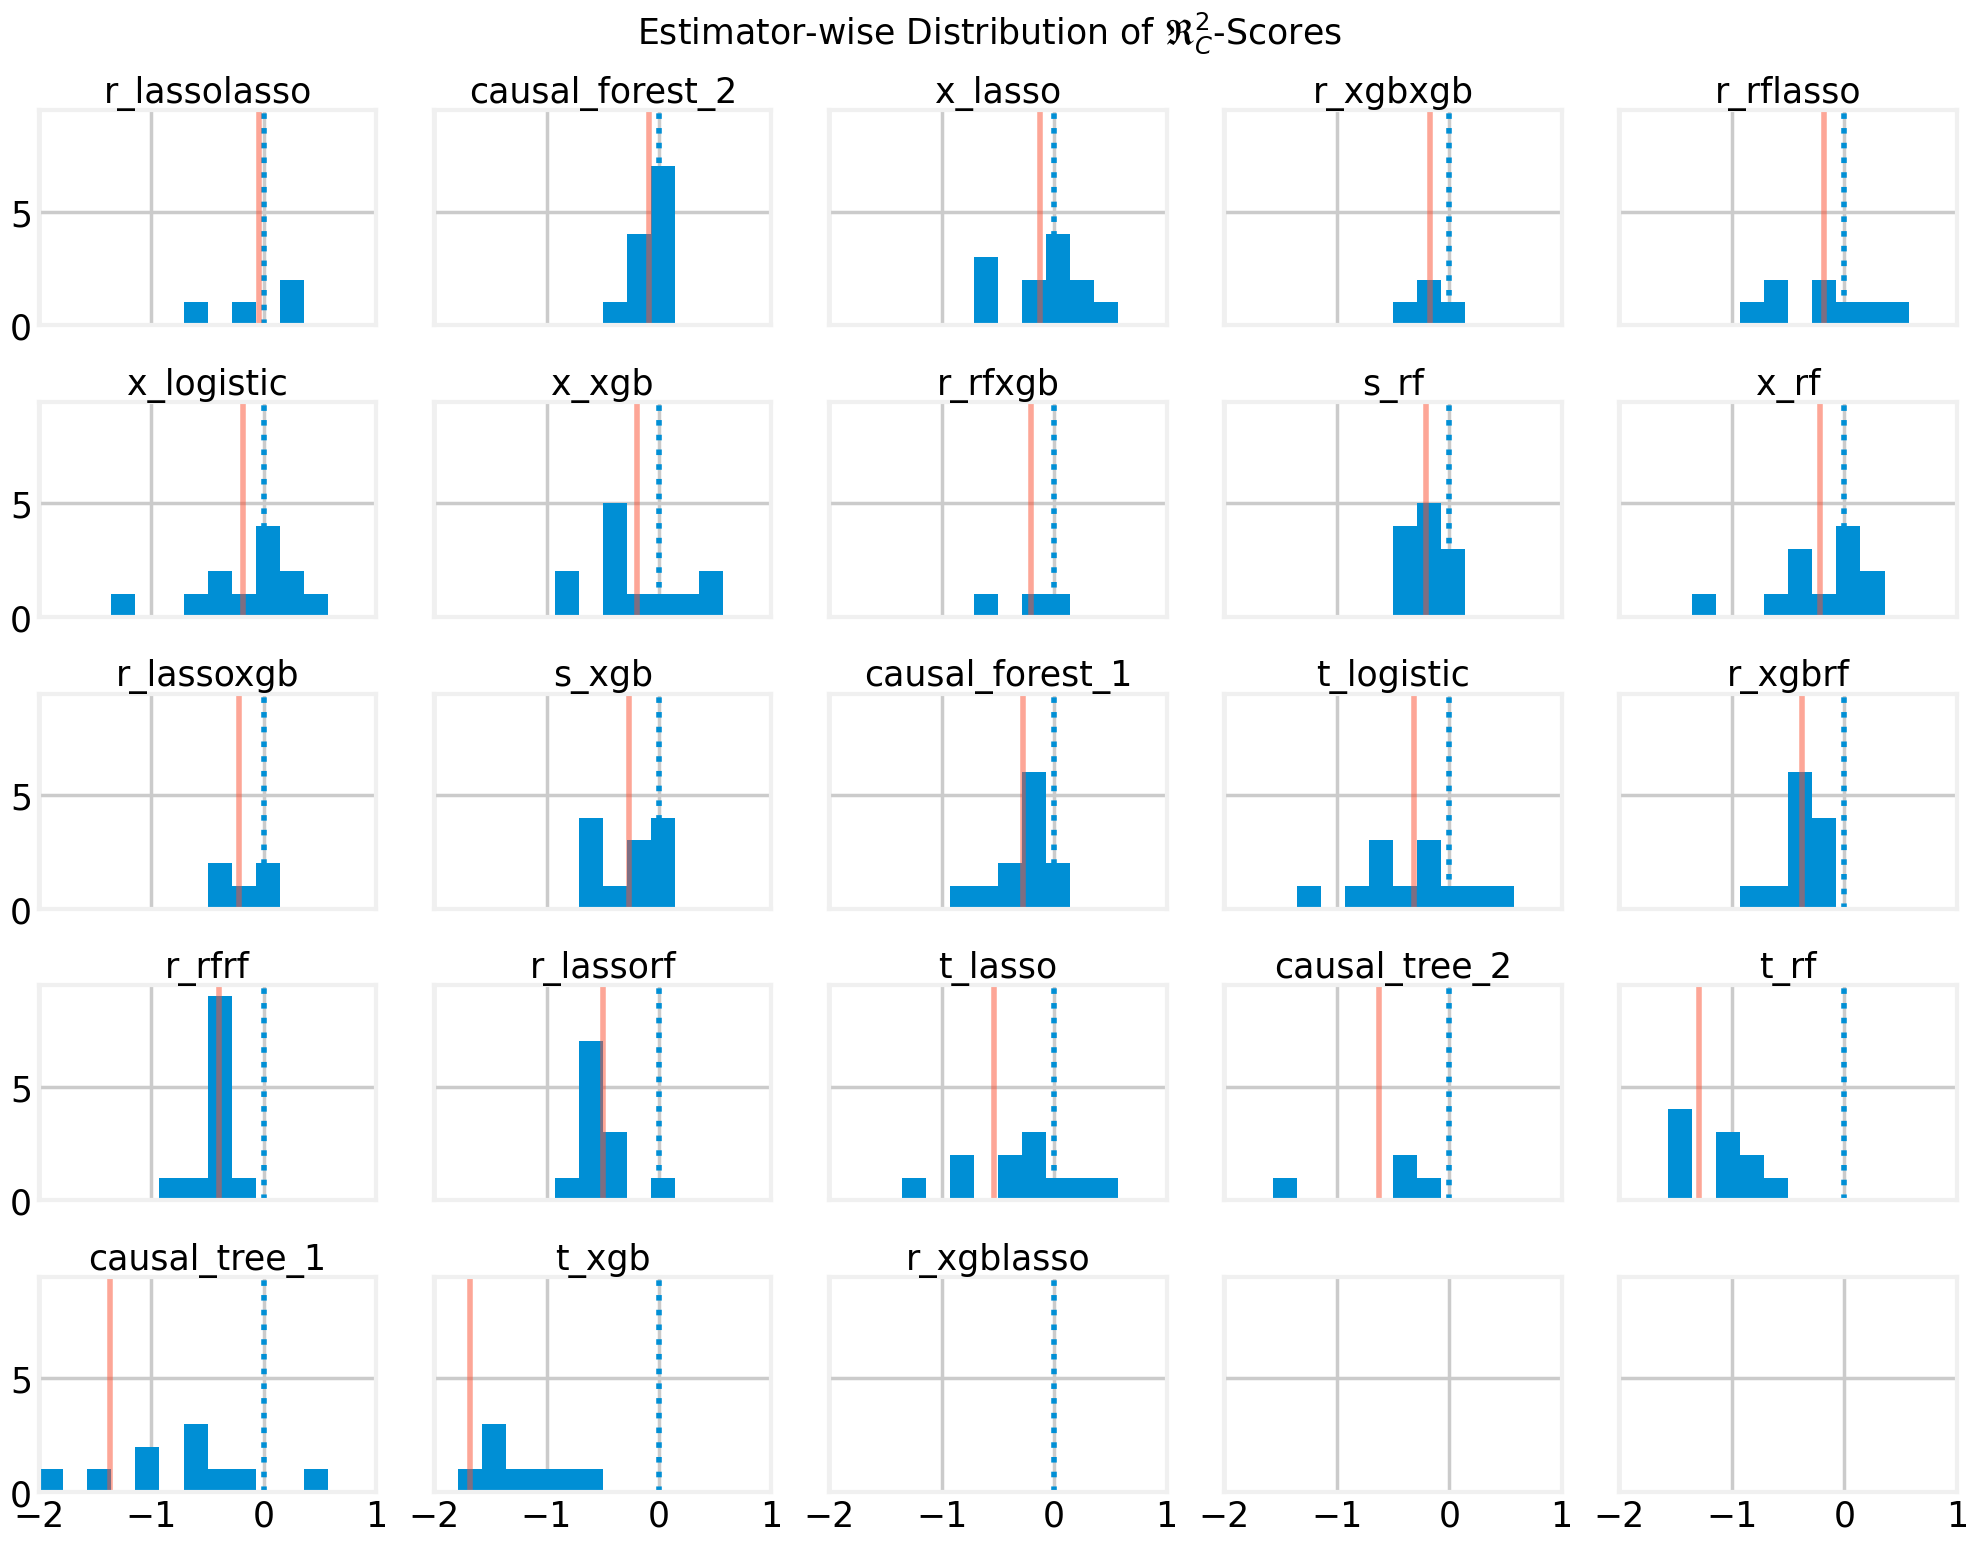

In [20]:
f, axes = plt.subplots(5, 5, figsize=[20, 15], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(all_estimators):
    ax = axes[i]
    ax.hist(cr2_plot_data[estimator]["cr2_val"], bins = np.linspace(-2,1,15))
    ax.axvline(0, alpha=1., linestyle=':')
    ax.axvline(cr2_plot_data[estimator]["cr2_val"].mean(), linestyle='-', 
               color=colors[1], alpha=0.5)
    ax.set_title(estimator)
    ax.set_xticks([-2, -1, 0, 1.])
    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle(r"Estimator-wise Distribution of $\mathfrak{R}_C^2$-Scores", y = 1.03)
savfig = False
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome}_estimator_wise_r2.pdf")
plt.show()

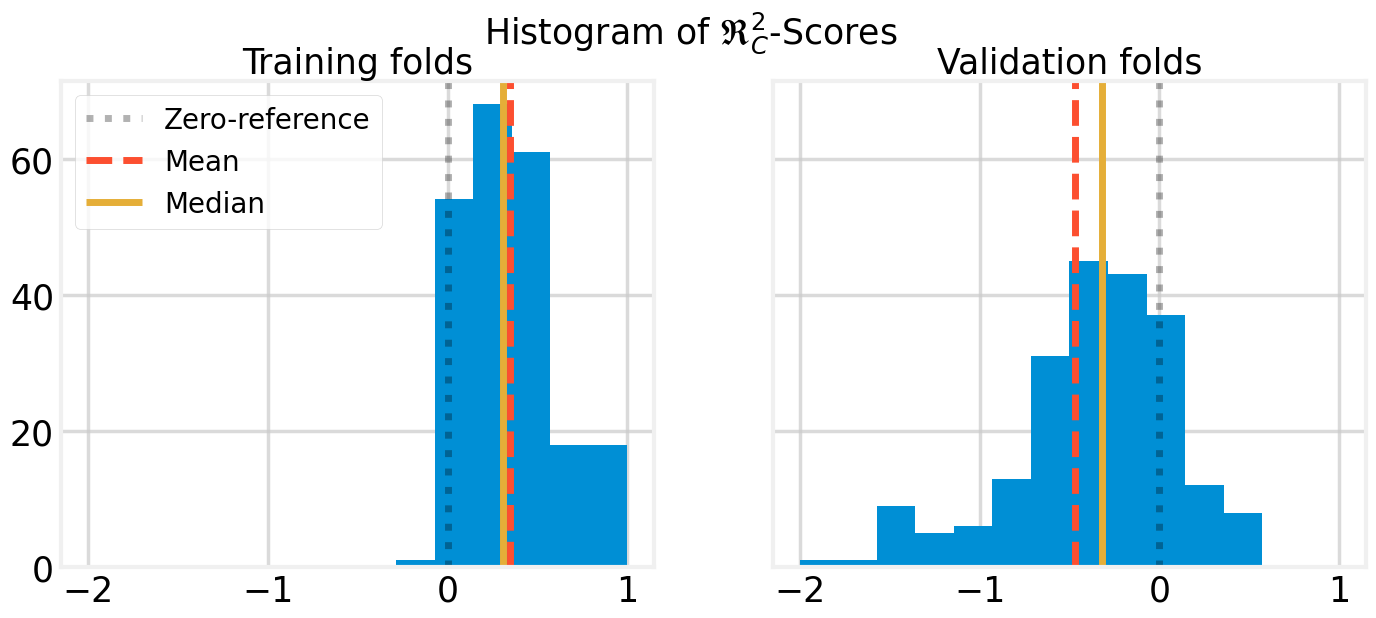

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, figsize = [15, 6])

ax1.hist(all_cr2_scores_train, bins = np.linspace(-2,1,15))
ax1.axvline(0, alpha=.3, color='k', linestyle=':',linewidth=5.,
           label="Zero-reference")
ax1.axvline(all_cr2_scores_train.mean(), linestyle='--', color=colors[1], alpha=1,linewidth=5.,
            label="Mean")
ax1.axvline(all_cr2_scores_train.median(), linestyle='-', color=colors[2], alpha=1.,linewidth=5.,
            label="Median")
ax1.set_title("Training folds")
ax1.legend(fontsize=20)
ax1.grid(True, alpha = 0.7)

ax2.hist(all_cr2_scores_val, bins = np.linspace(-2,1,15))
ax2.axvline(0, alpha=.3, color='k', linestyle=':',linewidth=5.,
           label="O-reference")
ax2.axvline(all_cr2_scores_val.mean(), linestyle='--', color=colors[1], alpha=1,
            linewidth=5.,
           label="Mean")
ax2.axvline(all_cr2_scores_val.median(), linestyle='-', color=colors[2], alpha=1,
            linewidth=5.,
           label="Median")
ax2.set_title("Validation folds")
ax2.grid(True, alpha = 0.7)
plt.suptitle(r"Histogram of $\mathfrak{R}_C^2$-Scores",  y=1.0)

savfig = False
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome}_distribution_r2.pdf")
plt.show()

Takeaways: Poor prediction performance
1. Calibration plots show that the validation set is too small to accurately gauge prediction accuracy of CATE estimators.  
2. $C-R^2$ scatter plots show further evidence of overfitting. (training scores are systematically higher than validation scores).   
3. $C-R^2$ histograms show that across all estimators and 12 different training-validation data splits, the overwhelming majority of scores is less than 0.5,  
i.e. only reduces l1-variability by 50% from the ATE constant predictor baseline.

## 3. Monotonicity

- Top estimators are computed in 04a
- Refer to `06_plots` for the monotonicity boxplot

In [22]:
top_estimator_names = joblib.load(f"output/analysis/{outcome}/{outcome}_top_estimator_names.pkl")
print(top_estimator_names)

['x_logistic', 'x_lasso', 't_logistic', 'x_rf', 't_lasso', 'x_xgb']


In [ ]:
# Ensure tuned_params refers to the same object loaded above (per-split if available)
# tuned_params = joblib.load(f"output/params/{outcome}/{outcome}_tuned_params.pkl")

### 3.1. Monotinicity with respect to 5 bins  

In [23]:
monotonicity_df = get_monotonicity_results(fitted_libraries, top_estimator_names, 
                                           n_bins = 5, dir_neg = dir_neg)

In [24]:
monotonicity_df.round(2)

[0.0,0.2] vs                  [0.2, 0.4]  \
s_xgb                                                0.50   
s_rf                                                 0.75   
t_lasso                                              0.75   
t_logistic                                           0.25   
t_rf                                                 0.75   
t_xgb                                                0.00   
x_lasso                                              0.75   
x_logistic                                           0.50   
x_rf                                                 0.75   
x_xgb                                                0.75   
r_lassolasso                                         0.50   
r_lassoxgb                                           0.25   
r_lassorf                                            0.25   
r_rflasso                                            0.75   
r_rfrf                                               0.75   
r_rfxgb                                              0.25   
r_xgblasso                                           0.00   
r_xgbrf                                              0.00   
r_xgbxgb                                             0.00   
causal_tree_1                                        0.50   
causal_tree_2                                        0.50   
causal_forest_1                                      0.00   
causal_forest_2                                      0.00   
mean                                                 0.41   
top6_mean                                            0.62   

                 [0.2,0.4] vs                  [0.4, 0.6]  \
s_xgb                                                0.25   
s_rf                                                 0.50   
t_lasso                                              0.25   
t_logistic                                           0.50   
t_rf                                                 0.50   
t_xgb                                                0.50   
x_lasso                                              0.50   
x_logistic                                           0.25   
x_rf                                                 0.25   
x_xgb                                                0.25   
r_lassolasso                                         0.25   
r_lassoxgb                                           0.25   
r_lassorf                                            0.25   
r_rflasso                                            0.50   
r_rfrf                                               0.25   
r_rfxgb                                              0.25   
r_xgblasso                                           0.00   
r_xgbrf                                              0.50   
r_xgbxgb                                             0.25   
causal_tree_1                                        0.00   
causal_tree_2                                        0.25   
causal_forest_1                                      0.75   
causal_forest_2                                      1.00   
mean                                                 0.36   
top6_mean                                            0.33   

                 [0.4,0.6] vs                  [0.6, 0.8]  \
s_xgb                                                0.50   
s_rf                                                 0.50   
t_lasso                                              0.75   
t_logistic                                           0.75   
t_rf                                                 0.25   
t_xgb                                                0.50   
x_lasso                                              0.75   
x_logistic                                           0.75   
x_rf                                                 0.50   
x_xgb                                                0.50   
r_lassolasso                                         0.75   
r_lassoxgb                                           0.25   
r_lassorf                                         

Remark: Top estimators determined using the methodology in notebook 04a.

In [25]:
joblib.dump(monotonicity_df, f"output/analysis/{outcome}/{outcome}_monotonicity_df.pkl")

['output/analysis/fausebal/fausebal_monotonicity_df.pkl']

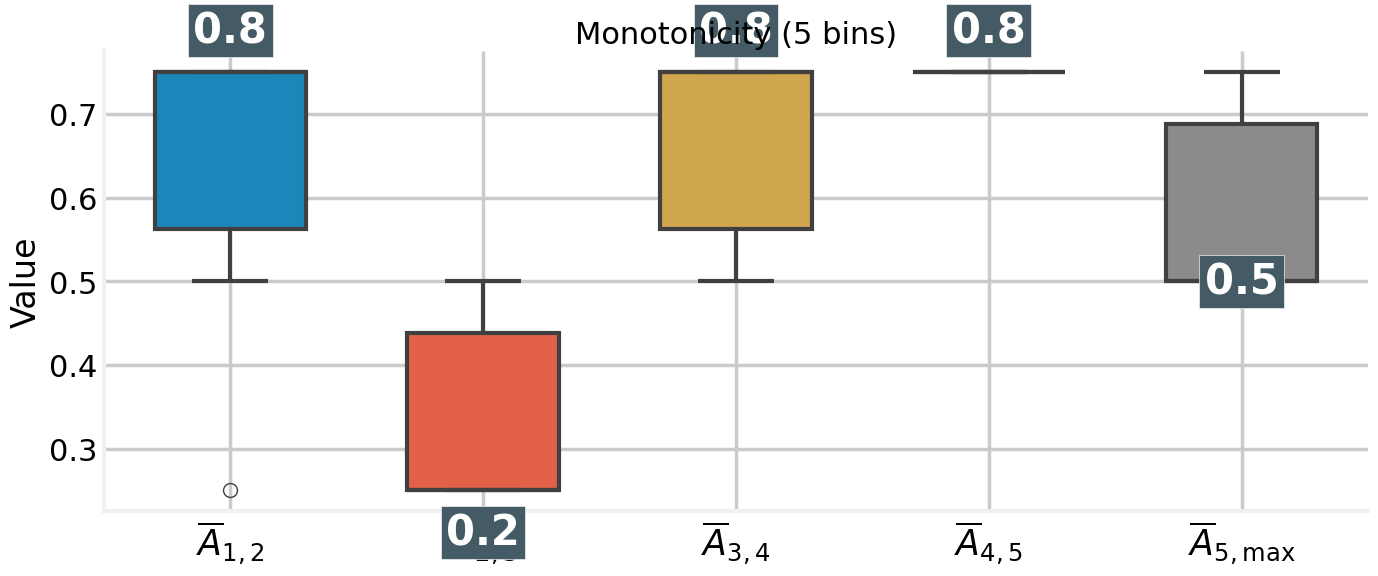

In [32]:
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

stick = 'A'
ticks1 = [r'$\overline{%s}_{%d,%d}$'%(stick, i, i+1) for i in range(1, 5)]
ticks1.append(r'$\overline{%s}_{5,\max}$'%(stick))

# Single plot using monotonicity_df only
f, ax = plt.subplots(1, 1, figsize=[14, 6])

plot_df = monotonicity_df.drop(index=["mean", "top6_mean"], errors="ignore")
top6 = top_estimator_names
plot_df = plot_df.loc[plot_df.index.intersection(top6)]
box_plot = sns.boxplot(data=plot_df, ax=ax, fliersize=10, linewidth=3, width=.6)

# Add median labels on boxes
lines = ax.get_lines()
categories = ax.get_xticks()
for cat in categories:
    y = round(lines[4 + cat*6].get_ydata()[0], 1)  # median line
    ax.text(cat, y, f'{y}', ha='center', va='center', fontweight='bold',
            size=30, color='white', bbox=dict(facecolor='#445A64'))

# Ticks, labels, style
ax.set_xticklabels(ticks1, fontsize=25)
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Monotonicity (5 bins)")
ax.set_ylabel("Value", fontsize=24)

plt.tight_layout()

savfig = False
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome}_monotonicity_box_plot.pdf")
plt.show()

### 3.2. Comparing quantile-based top subgroup with its complement

In [27]:
new_monotonicity_df = get_monotonicity_results(fitted_libraries, top_estimator_names=top_estimator_names,
                                               q_values=q_values, dir_neg=dir_neg)

In [28]:
new_monotonicity_df.round(2)

[0.0,0.9] vs [0.9, 1.]  [0.0,0.8] vs [0.8, 1.]  \
s_xgb                              0.25                    0.50   
s_rf                               0.50                    0.25   
t_lasso                            0.75                    1.00   
t_logistic                         1.00                    0.50   
t_rf                               0.25                    0.50   
t_xgb                              1.00                    0.75   
x_lasso                            1.00                    1.00   
x_logistic                         0.75                    0.75   
x_rf                               1.00                    0.75   
x_xgb                              0.75                    0.75   
r_lassolasso                       1.00                    1.00   
r_lassoxgb                         0.50                    0.50   
r_lassorf                          0.75                    0.75   
r_rflasso                          0.75                    0.75   
r_rfrf                             0.75                    0.75   
r_rfxgb                            0.50                    0.50   
r_xgblasso                         0.50                    0.50   
r_xgbrf                            0.75                    0.75   
r_xgbxgb                           0.50                    0.50   
causal_tree_1                      0.50                    0.00   
causal_tree_2                      0.25                    0.25   
causal_forest_1                    0.25                    0.50   
causal_forest_2                    0.25                    0.50   
mean                               0.63                    0.61   
top6_mean                          0.88                    0.79   

                 [0.0,0.7] vs [0.7, 1.]  [0.0,0.6] vs [0.6, 1.]  \
s_xgb                              0.25                    0.25   
s_rf                               0.50                    0.25   
t_lasso                            0.50                    1.00   
t_logistic                         0.75                    0.75   
t_rf                               0.00                    0.00   
t_xgb                              0.50                    0.50   
x_lasso                            0.50                    0.75   
x_logistic                         0.50                    0.75   
x_rf                               0.50                    0.50   
x_xgb                              0.75                    0.75   
r_lassolasso                       0.75                    0.50   
r_lassoxgb                         0.25                    0.25   
r_lassorf                          0.50                    0.50   
r_rflasso                          0.75                    0.75   
r_rfrf                             0.25                    0.25   
r_rfxgb                            0.75                    0.75   
r_xgblasso                         0.50                    0.50   
r_xgbrf                            0.00                    0.00   
r_xgbxgb                           0.75                    0.75   
causal_tree_1                      0.00                    0.50   
causal_tree_2                      0.50                    0.25   
causal_forest_1                    0.25                    0.25   
causal_forest_2                    0.50                    0.25   
mean                               0.46                    0.48   
top6_mean                          0.58                    0.75   

                 [0.0,0.5] vs [0.5, 1.]  
s_xgb                              0.25  
s_rf                               0.00  
t_lasso                            0.50  
t_logistic                         0.50  
t_rf                               0.50  
t_xgb                              0.50  
x_lasso                            0.25  
x_logistic                         0.75  
x_rf                               0.75  
x_xgb                              0.75  
r_lassolasso                       0.25  
r_lassoxgb                 

In [29]:
joblib.dump(new_monotonicity_df, f"output/analysis/{outcome}/{outcome}_new_monotonicity_df.pkl")

['output/analysis/fausebal/fausebal_new_monotonicity_df.pkl']

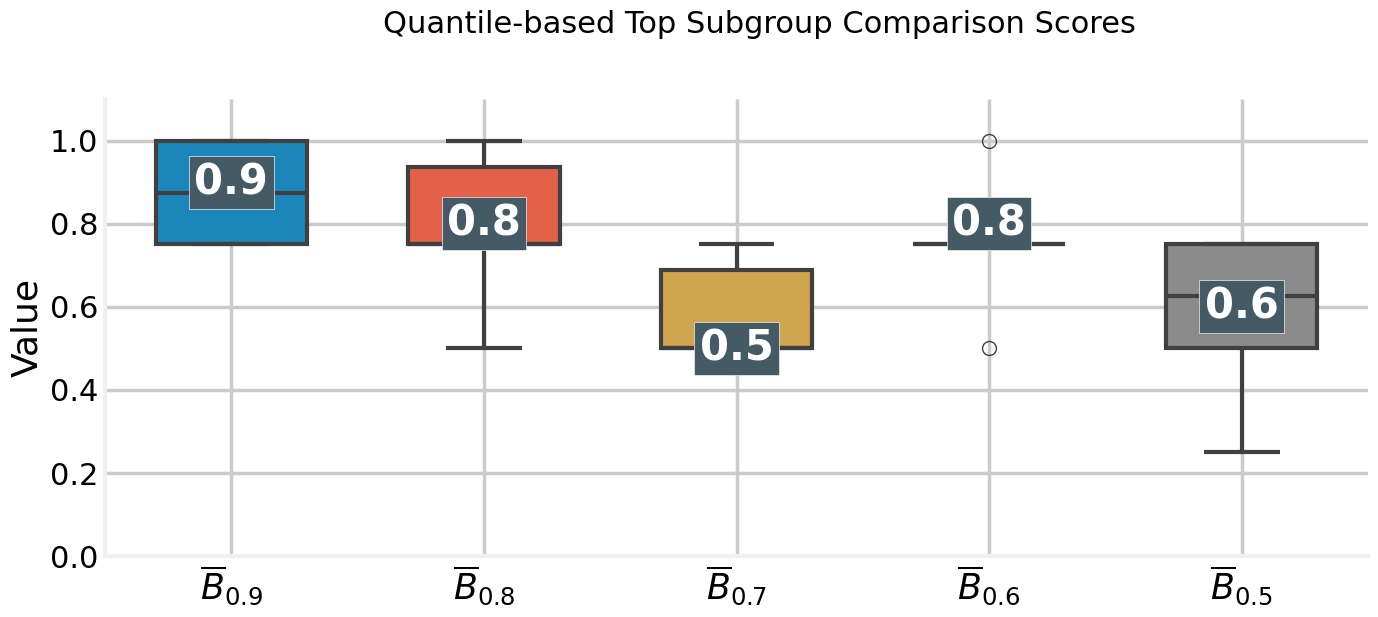

In [33]:
# Tick labels for TC (quantile-based)
stick = 'B'
qs = [0.1, 0.2, 0.3, 0.4, 0.5]
# Complement quantiles for TC; use f-strings with explicit braces for mathtext
ticks2 = [rf'$\overline{{{stick}}}_{{{1-q:.1f}}}$' for q in qs]
# TC-only monotonicity boxplot (quantile-based)
f, ax1 = plt.subplots(1, 1, figsize = [14, 6])

ax = ax1
top6 = top_estimator_names[:6]
plot_df = new_monotonicity_df.drop(index={"mean", "top6_mean"}, errors="ignore")
plot_df = plot_df.loc[plot_df.index.intersection(top6)]
box_plot = sns.boxplot(data=plot_df, ax=ax, fliersize=10, linewidth=3, width=.6)

# Add median labels on boxes
lines = ax.get_lines()
categories = ax.get_xticks()
for cat in categories:
    y = round(lines[4 + cat*6].get_ydata()[0], 1)  # median line
    ax.text(
        cat,
        y,
        f"{y}",
        ha="center",
        va="center",
        fontweight="bold",
        size=30,
        color="white",
        bbox=dict(facecolor="#445A64"),
    )

# Ticks, limits, labels
ax.set_ylim((0, 1.1))
ax.set_xticks(np.arange(len(ticks2)))
ax.set_xticklabels(ticks2, fontsize=25)
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax1.set_ylabel("Value", fontsize=26)
plt.suptitle("Quantile-based Top Subgroup Comparison Scores", x=.55, y=1.03)
plt.tight_layout()

savfig = False
if savfig:
    plt.savefig("figs/TC_new_monotonicity_box_plot.pdf", bbox_inches='tight')
plt.show()


## 4. Stability of CATE estimators

### 4.1. Stability of quantile-based top subgroup

In this section, we examine the stability of the quantile-based subgroups by generalizing the notion of overlap.  
We consider the quantile-based top subgroup for q=0.2, and compute what percentage of its members are contained  
in the quantile-based top subgroup for other values of q, when the two subgroups are obtained from CATE estimators  
trained on different data splits.

In [29]:
library_names = ["pert_none", "pert_cv_0", "pert_cv_1"]
library = {}
for estimator_name in fitted_libraries["pert_none"].keys():
    list_of_estimators = []
    for library_name in library_names:
        list_of_estimators.append(fitted_libraries[library_name][estimator_name])
    library[estimator_name] = combine_estimator_versions(list_of_estimators)
stability_scores = {}
q0 = 0.1
q_values_v2 = [0.1, 0.2, 0.3, 0.4, 0.5]
for estimator_name, estimator in library.items():
    stability_scores[estimator_name] = get_top_subgroup_stability(estimator, q0, q_values_v2, dir_neg).round(2)

In [30]:
same_q_scores = []
diff_q_scores = []
for scores in stability_scores.values():
    same_q_scores.append(scores.loc[0.2,"mean coverage"])
    diff_q_scores.append(scores.loc[0.3,"mean coverage"])
scores_df = pd.DataFrame({"estimator" : list(stability_scores.keys()),
                          "0.2" : same_q_scores,
                          "0.3" : diff_q_scores})
scores_df = scores_df.set_index("estimator")
scores_df.drop(index = ["r_lassoxgb"], inplace = True)

In [31]:
scores_df

0.2   0.3
estimator                  
s_xgb            0.34  0.46
s_rf             0.54  0.64
t_lasso          0.73  0.80
t_logistic       0.69  0.75
t_rf             0.59  0.71
t_xgb            0.67  0.79
x_lasso          0.73  0.80
x_logistic       0.65  0.75
x_rf             0.65  0.76
x_xgb            0.43  0.51
r_lassolasso     0.70  0.78
r_lassorf        0.65  0.75
r_rflasso        0.57  0.73
r_rfrf           0.68  0.78
r_rfxgb           NaN   NaN
r_xgblasso        NaN   NaN
r_xgbrf          0.65  0.75
r_xgbxgb          NaN   NaN
causal_tree_1    0.34  0.47
causal_tree_2     NaN   NaN
causal_forest_1  0.65  0.78
causal_forest_2  0.71  0.84

### 4.2. Overlaps of quantile-based subgroups

In [32]:
all_overlaps = get_overlap_values(fitted_libraries, 0.8, 1.0, compare_across = "all")

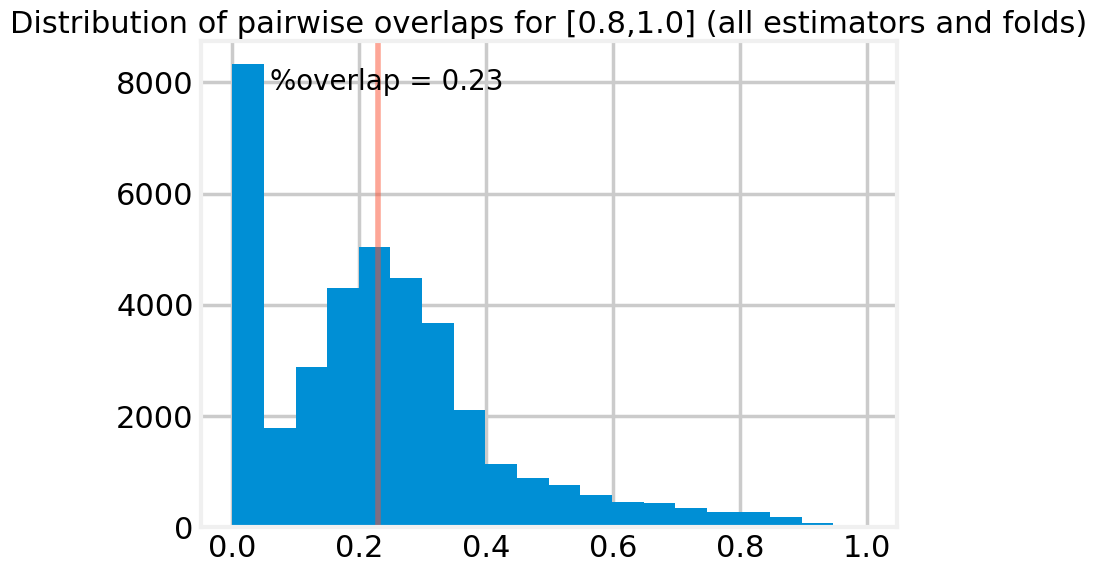

In [33]:
plt.hist(all_overlaps, bins = 20, zorder = 1)
plt.title("Distribution of pairwise overlaps for [0.8,1.0] (all estimators and folds)")
mean_overlap = all_overlaps.mean()
plt.axvline(x = mean_overlap, linestyle='-', color=colors[1], alpha=0.5, zorder = 2)
ax = plt.gca()
plt.annotate("%overlap = {:.2f}".format(mean_overlap),
             xy = (0.1, 0.9), xycoords = ax.transAxes,
             fontsize = 20)
plt.show()

In [34]:
estimator_overlaps = get_overlap_values(fitted_libraries, 0.8, 1.0, compare_across = "estimators", fold = 0)

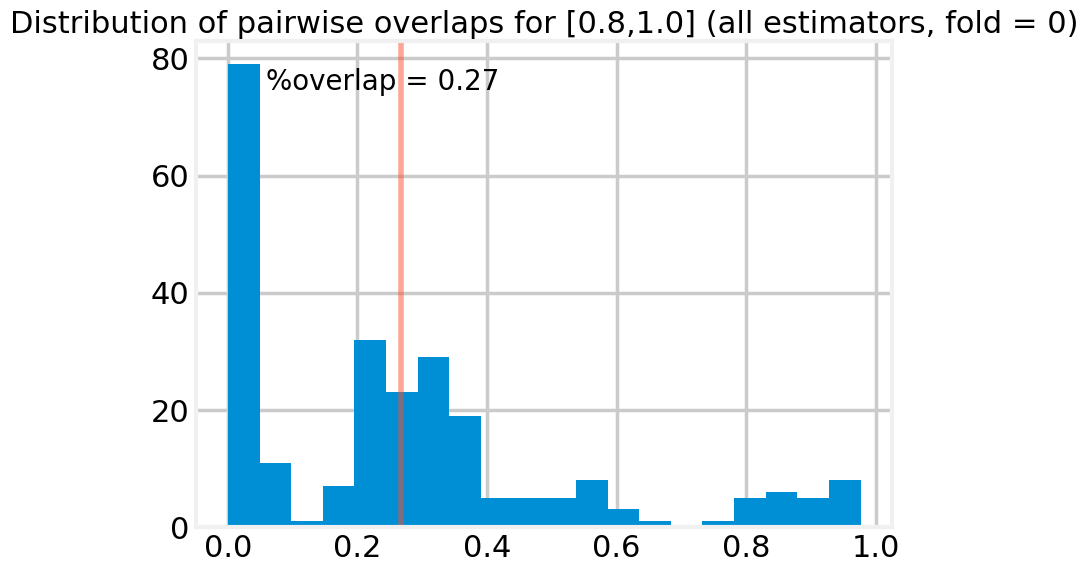

In [35]:
plt.hist(estimator_overlaps, bins = 20, zorder = 1)
plt.title("Distribution of pairwise overlaps for [0.8,1.0] (all estimators, fold = 0)")
mean_overlap = estimator_overlaps.mean()
plt.axvline(x = mean_overlap, linestyle='-', color=colors[1], alpha=0.5, zorder = 2)
ax = plt.gca()
plt.annotate("%overlap = {:.2f}".format(mean_overlap),
             xy = (0.1, 0.9), xycoords = ax.transAxes,
             fontsize = 20)
plt.show()

In [36]:
# Get data to make plot
selected_estimators = list(fitted_libraries["pert_none"].keys())
selected_estimators.remove("r_lassoxgb")
overlap_plot_data = {}
for estimator in selected_estimators:
    overlap_plot_data[estimator] = get_overlap_values(fitted_libraries, 0.8, 1.0,
                                                      compare_across = "folds",
                                                      estimator = estimator)
# Order the estimators in decreasing order w.r.t. mean overlap
selected_estimators = np.array(selected_estimators)
estimator_argsort = np.argsort([-overlap_plot_data[estimator].mean() for estimator in selected_estimators])
selected_estimators = selected_estimators[estimator_argsort]

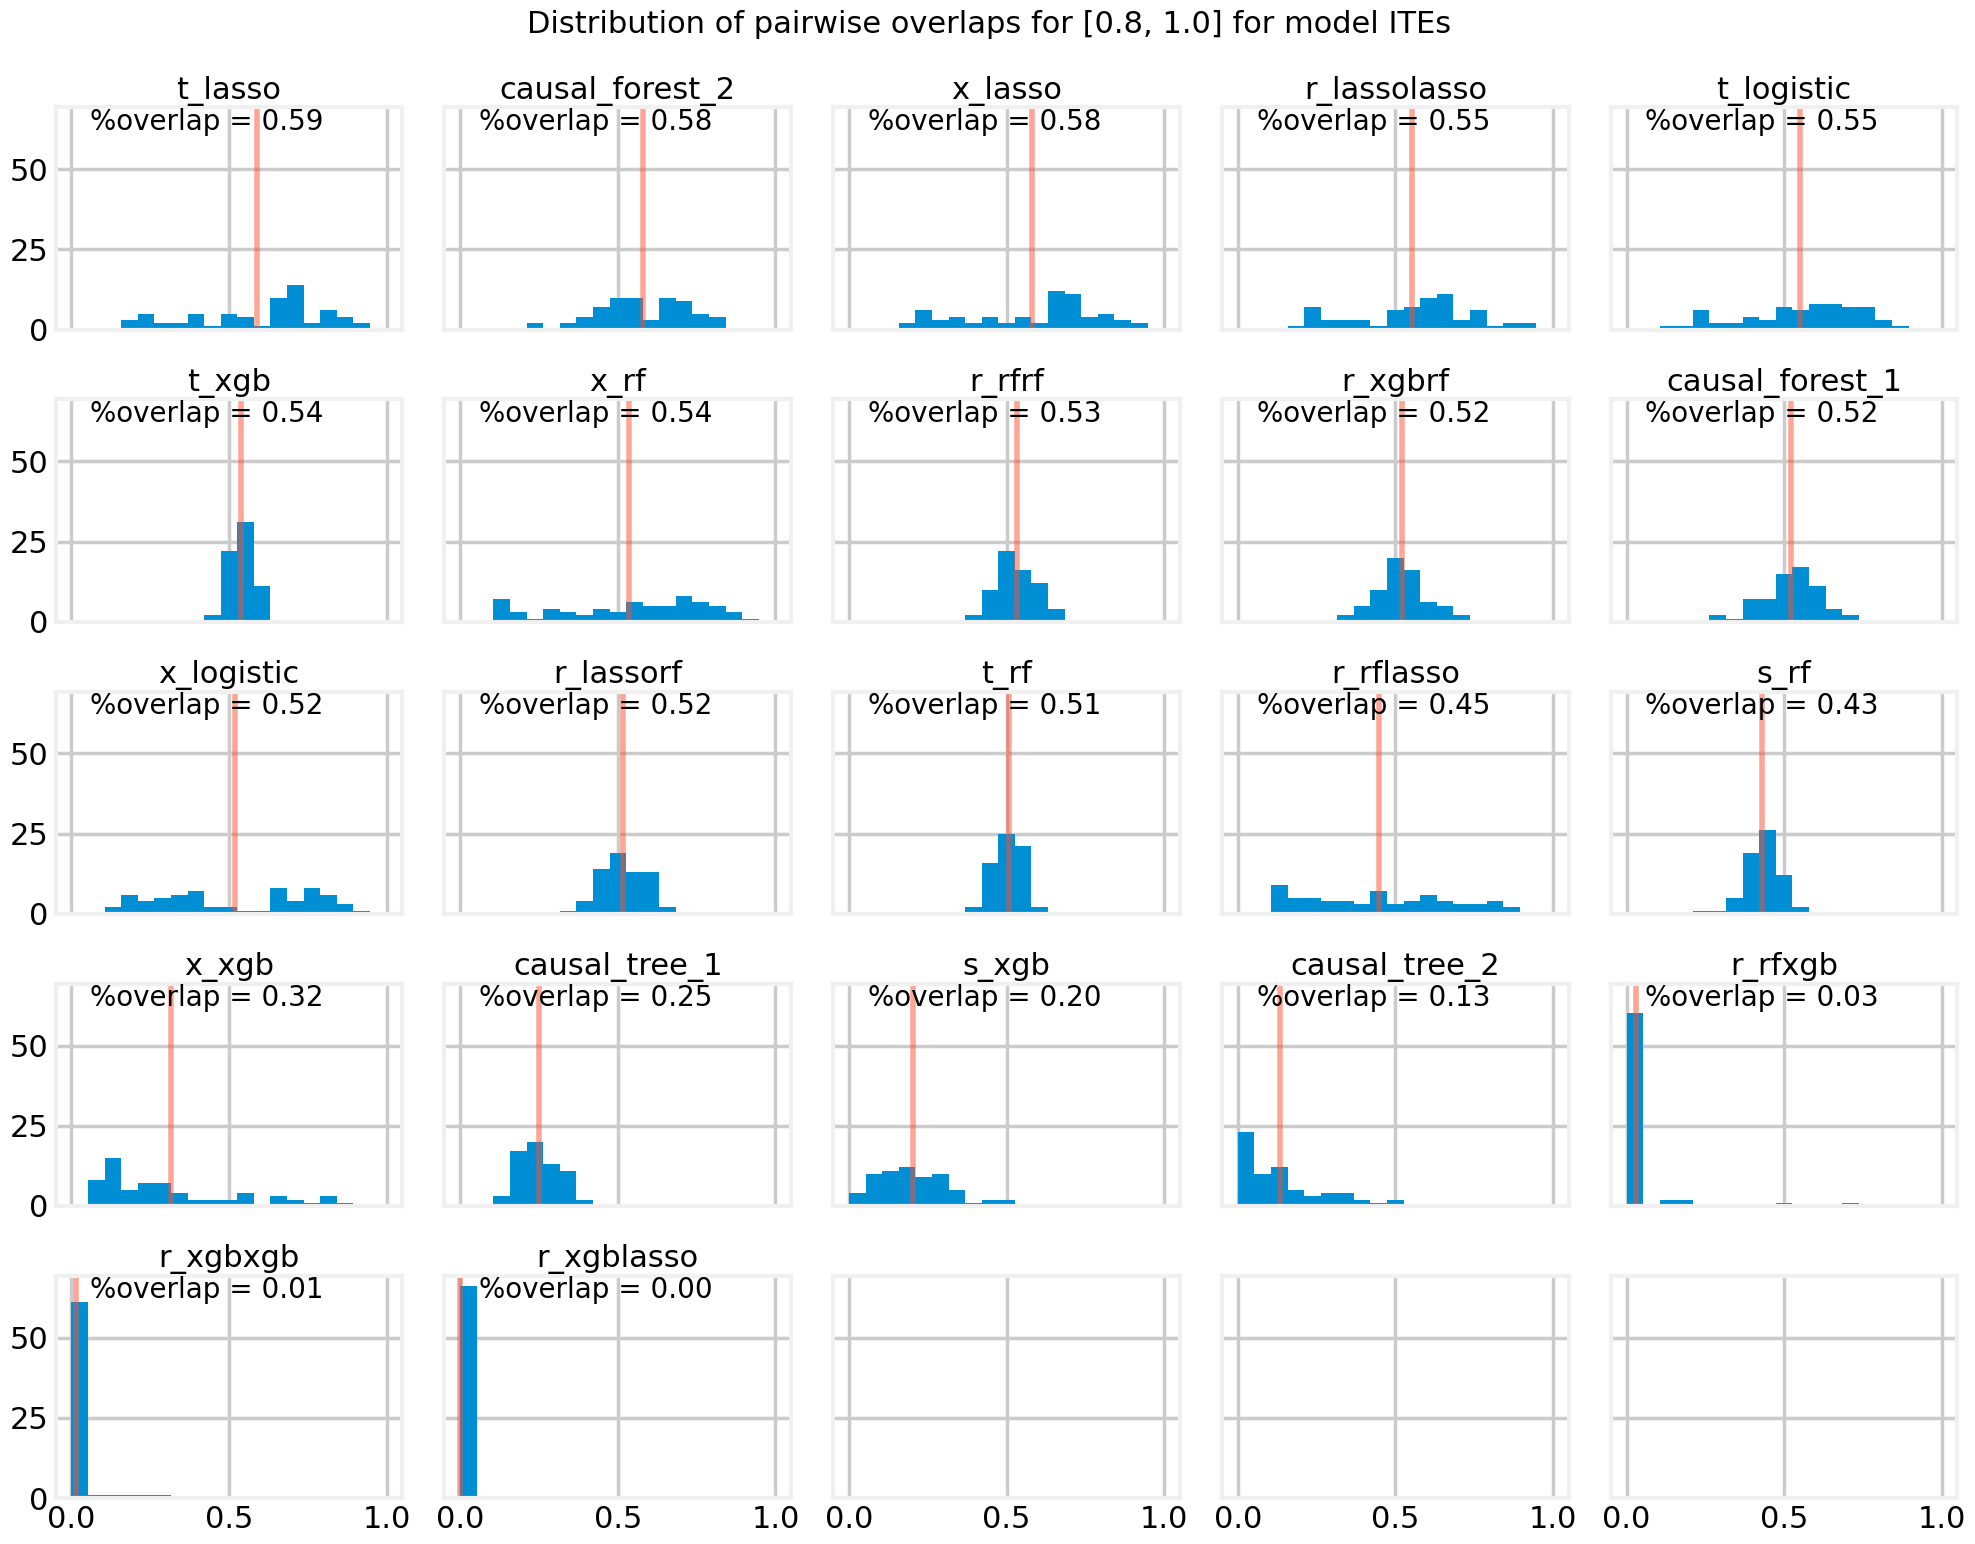

In [37]:
f, axes = plt.subplots(5, 5, figsize=[20, 15], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(selected_estimators):
    ax = axes[i]
    ax.hist(overlap_plot_data[estimator], bins = np.linspace(0, 1, 20))
    mean_overlap = overlap_plot_data[estimator].mean()
    ax.axvline(mean_overlap, linestyle='-', color=colors[1], alpha=0.5)
    ax.annotate("%overlap = {:.2f}".format(mean_overlap),
                xy = (.1, .9), xycoords = ax.transAxes,
                fontsize = 20)
    ax.set_title(estimator)
#    ax.set_xticks([-2, -1, 0, 1.])
#    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle("Distribution of pairwise overlaps for [0.8, 1.0] for model ITEs", y = 1.03)
plt.show()

In [38]:
# Get data to make plot
selected_estimators = list(fitted_libraries["pert_none"].keys())
selected_estimators.remove("r_lassoxgb")
overlap_plot_data = {}
for estimator in selected_estimators:
    overlap_plot_data[estimator] = get_overlap_values(fitted_libraries, 0.8, 1.0,
                                                      compare_across = "folds",
                                                      estimator = estimator)
# Order the estimators in decreasing order w.r.t. mean overlap
selected_estimators = np.array(selected_estimators)
estimator_argsort = np.argsort([-overlap_plot_data[estimator].mean() for estimator in selected_estimators])
selected_estimators = selected_estimators[estimator_argsort]

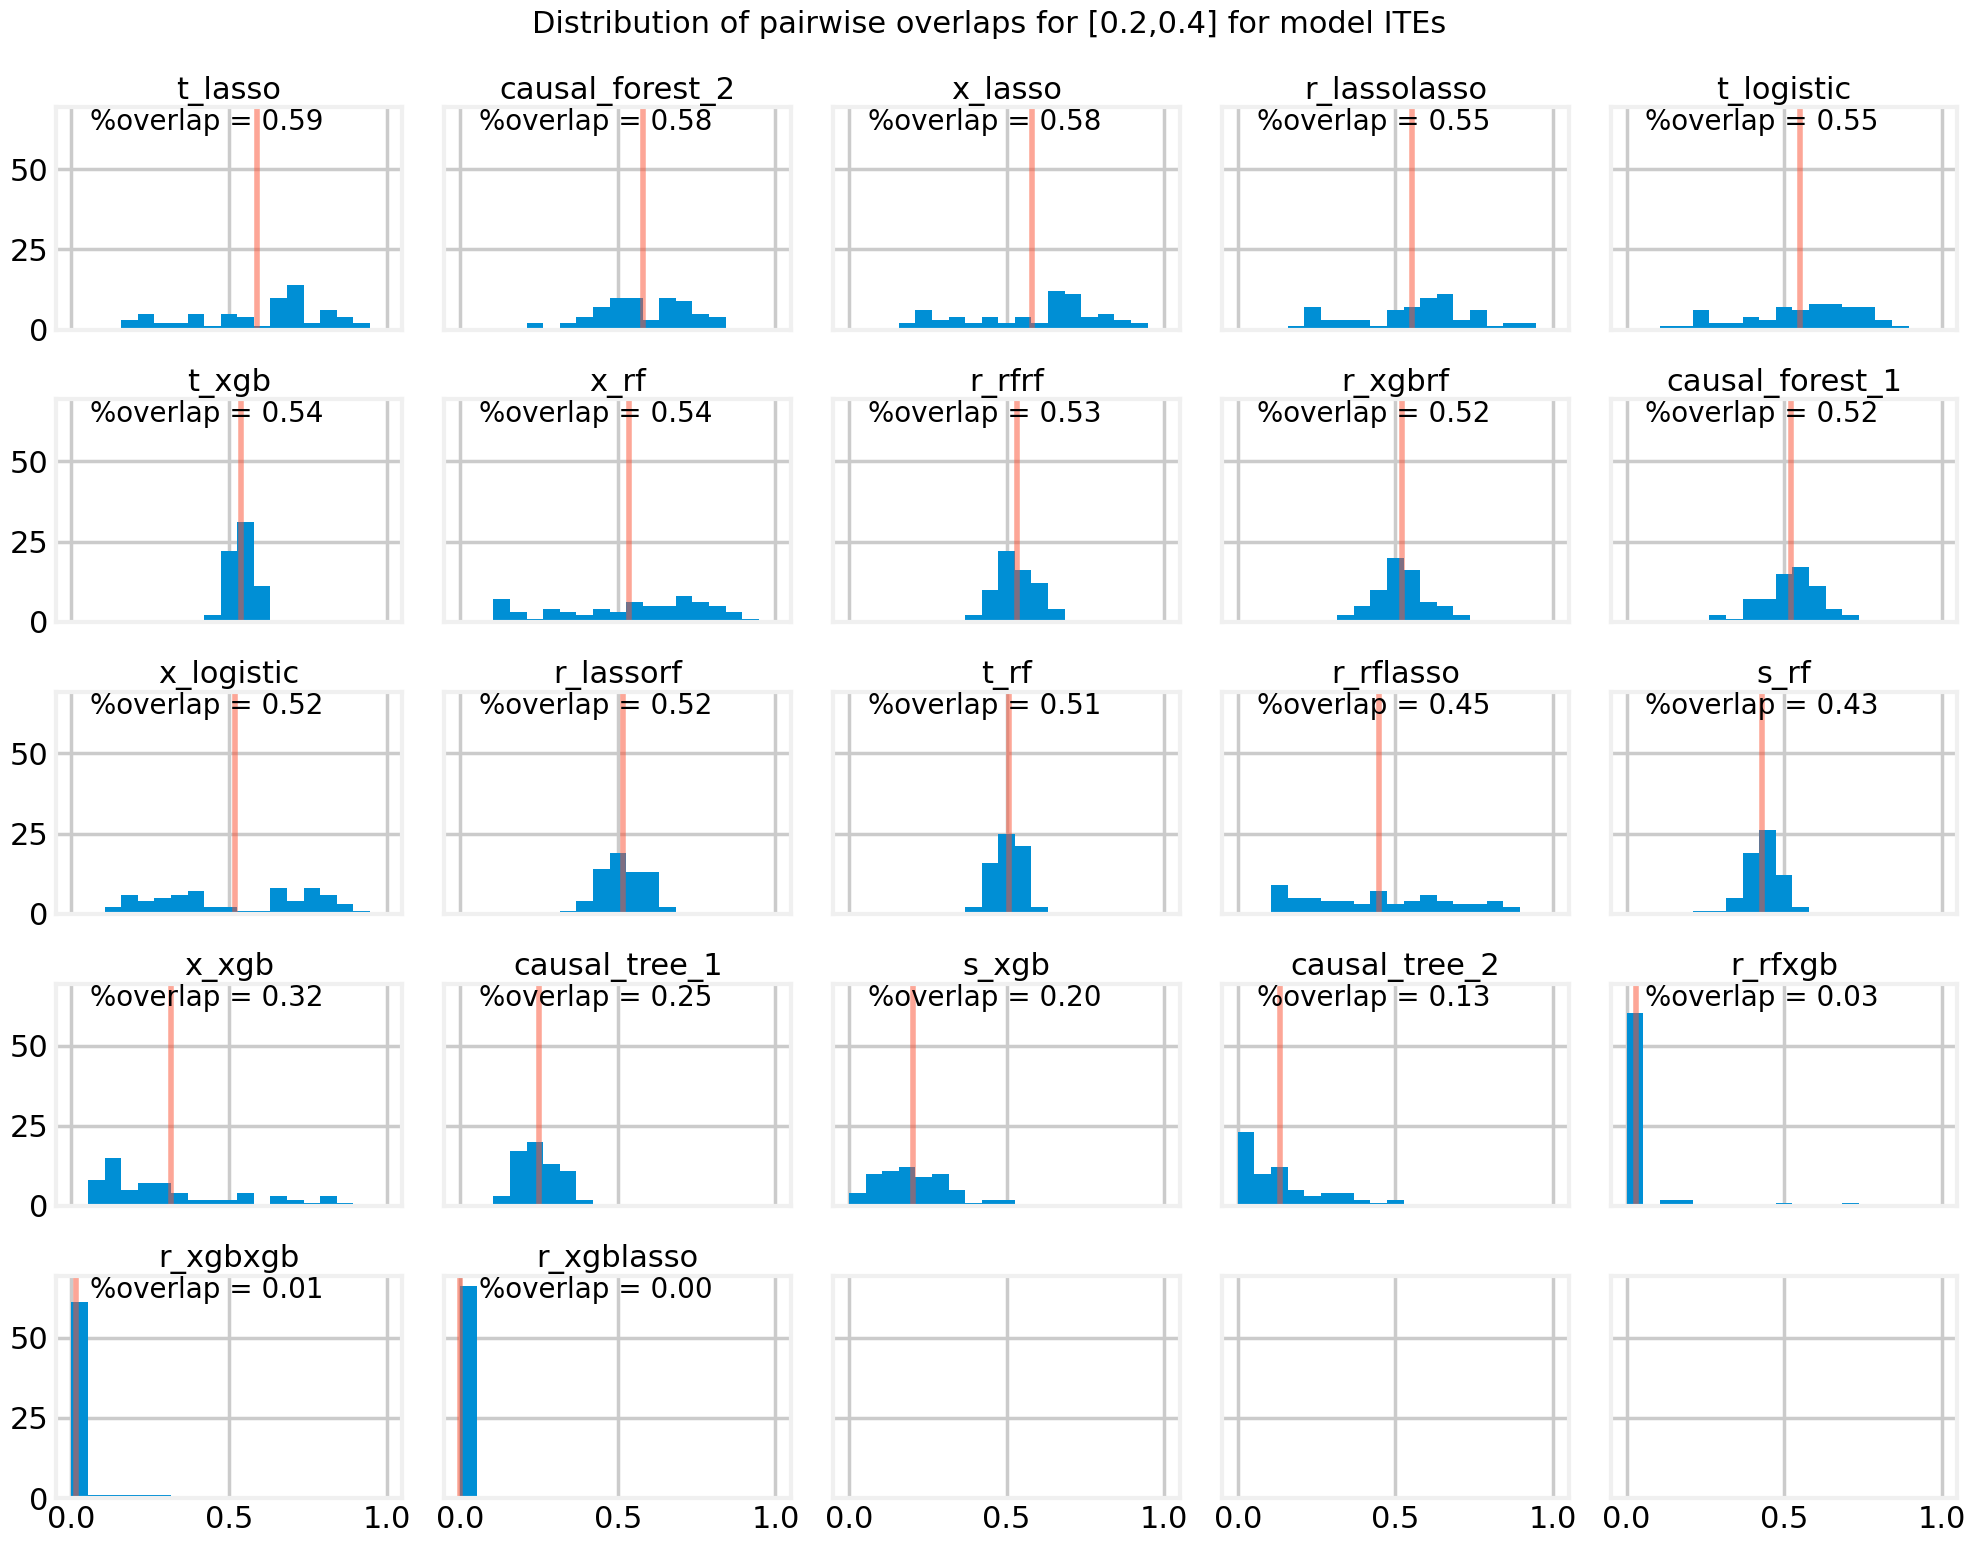

In [39]:
f, axes = plt.subplots(5, 5, figsize = [20, 15], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(selected_estimators):
    ax = axes[i]
    ax.hist(overlap_plot_data[estimator], bins = np.linspace(0, 1, 20))
    mean_overlap = overlap_plot_data[estimator].mean()
    ax.axvline(mean_overlap, linestyle='-', color=colors[1], alpha = 0.5)
    ax.annotate("%overlap = {:.2f}".format(mean_overlap),
                xy = (.1, .9), xycoords = ax.transAxes,
                fontsize = 20)
    ax.set_title(estimator)
#    ax.set_xticks([-2, -1, 0, 1.])
#    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle("Distribution of pairwise overlaps for [0.2,0.4] for model ITEs", y = 1.03)
plt.show()

### 4.3. Aggregate correlation statistics

In [40]:
all_correlations = get_r_values(fitted_libraries, compare_across = "all")
#all_correlations = all_correlations[~np.isnan(all_correlations)] In case of nan

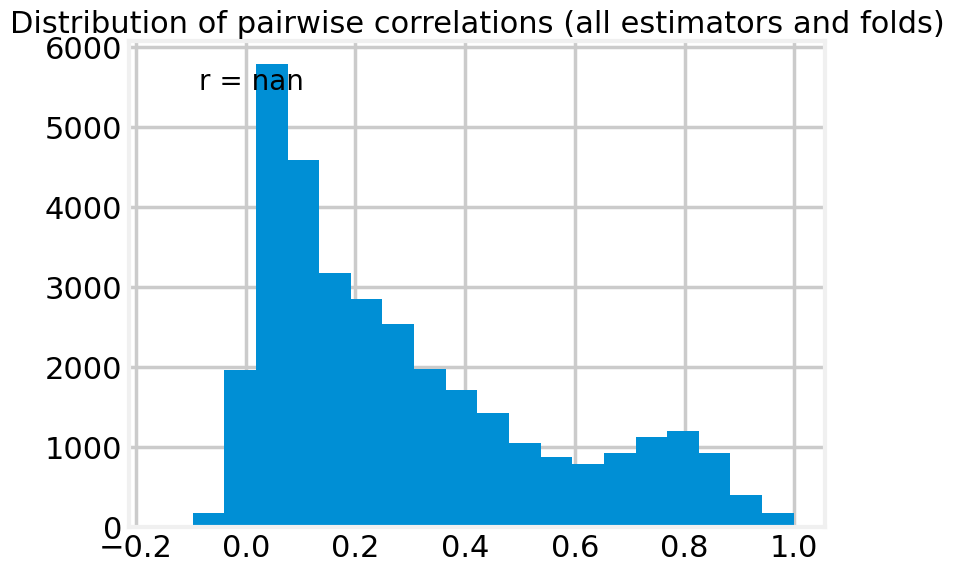

In [41]:
plt.hist(all_correlations, bins = 20, zorder = 1)
plt.title("Distribution of pairwise correlations (all estimators and folds)")
mean_r = all_correlations.mean()
plt.axvline(x = mean_r, linestyle='-', color=colors[1], alpha=0.5, zorder = 2)
ax = plt.gca()
plt.annotate("r = {:.2f}".format(mean_r),
             xy = (0.1, 0.9), xycoords = ax.transAxes,
             fontsize = 20)
plt.show()

### 4.4. Pairwise correlation for a single estimator when trained on different splits

In [42]:
marker_size = 20
alpha = 0.3

def make_model_CATE_pairplot(estimator, estimator_name = None):
    model_CATEs_df = pd.DataFrame({})
    for fold_no, result in estimator.results.items():
        model_CATEs_df[fold_no] = result.tau
    def corrfunc(x, y, **kwargs):
        r, _ = stats.pearsonr(x, y)
        ax = plt.gca()
        ax.annotate("r = {:.2f}".format(r),
                    xy = (.1, .9), xycoords = ax.transAxes,
                    fontsize = 20)
    g = sns.pairplot(model_CATEs_df, kind = "scatter", plot_kws = {"s" : marker_size,
                                                                   "alpha" : alpha})
    g = g.map_upper(corrfunc)
    g.fig.set_size_inches(15,15)
    title_string = "Pair plot for ITEs predicted by estimator when trained on 4 different folds"
    if estimator_name is not None:
        title_string += f": {estimator_name}"
    plt.suptitle(title_string, y = 1.03)
    plt.show()

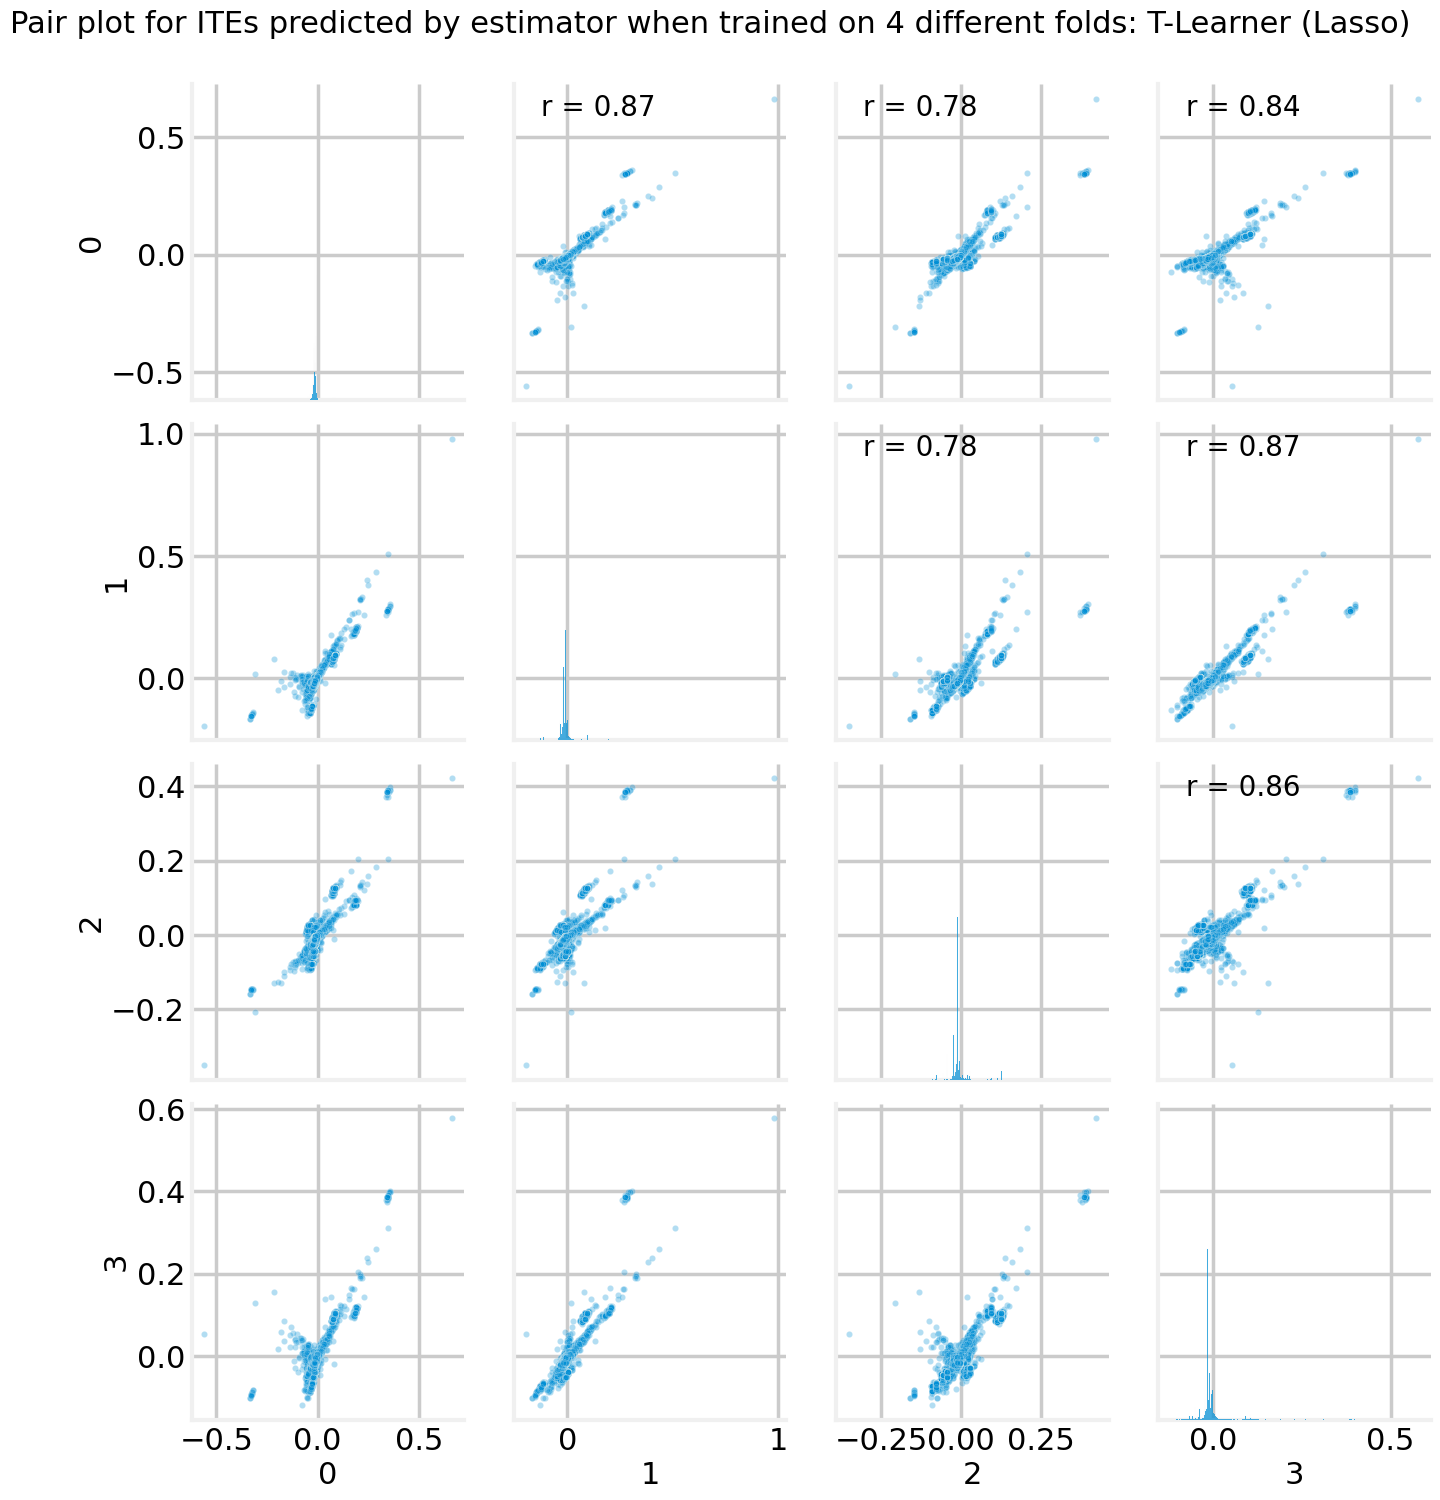

In [43]:
make_model_CATE_pairplot(fitted_libraries["pert_none"]["t_lasso"], "T-Learner (Lasso)")

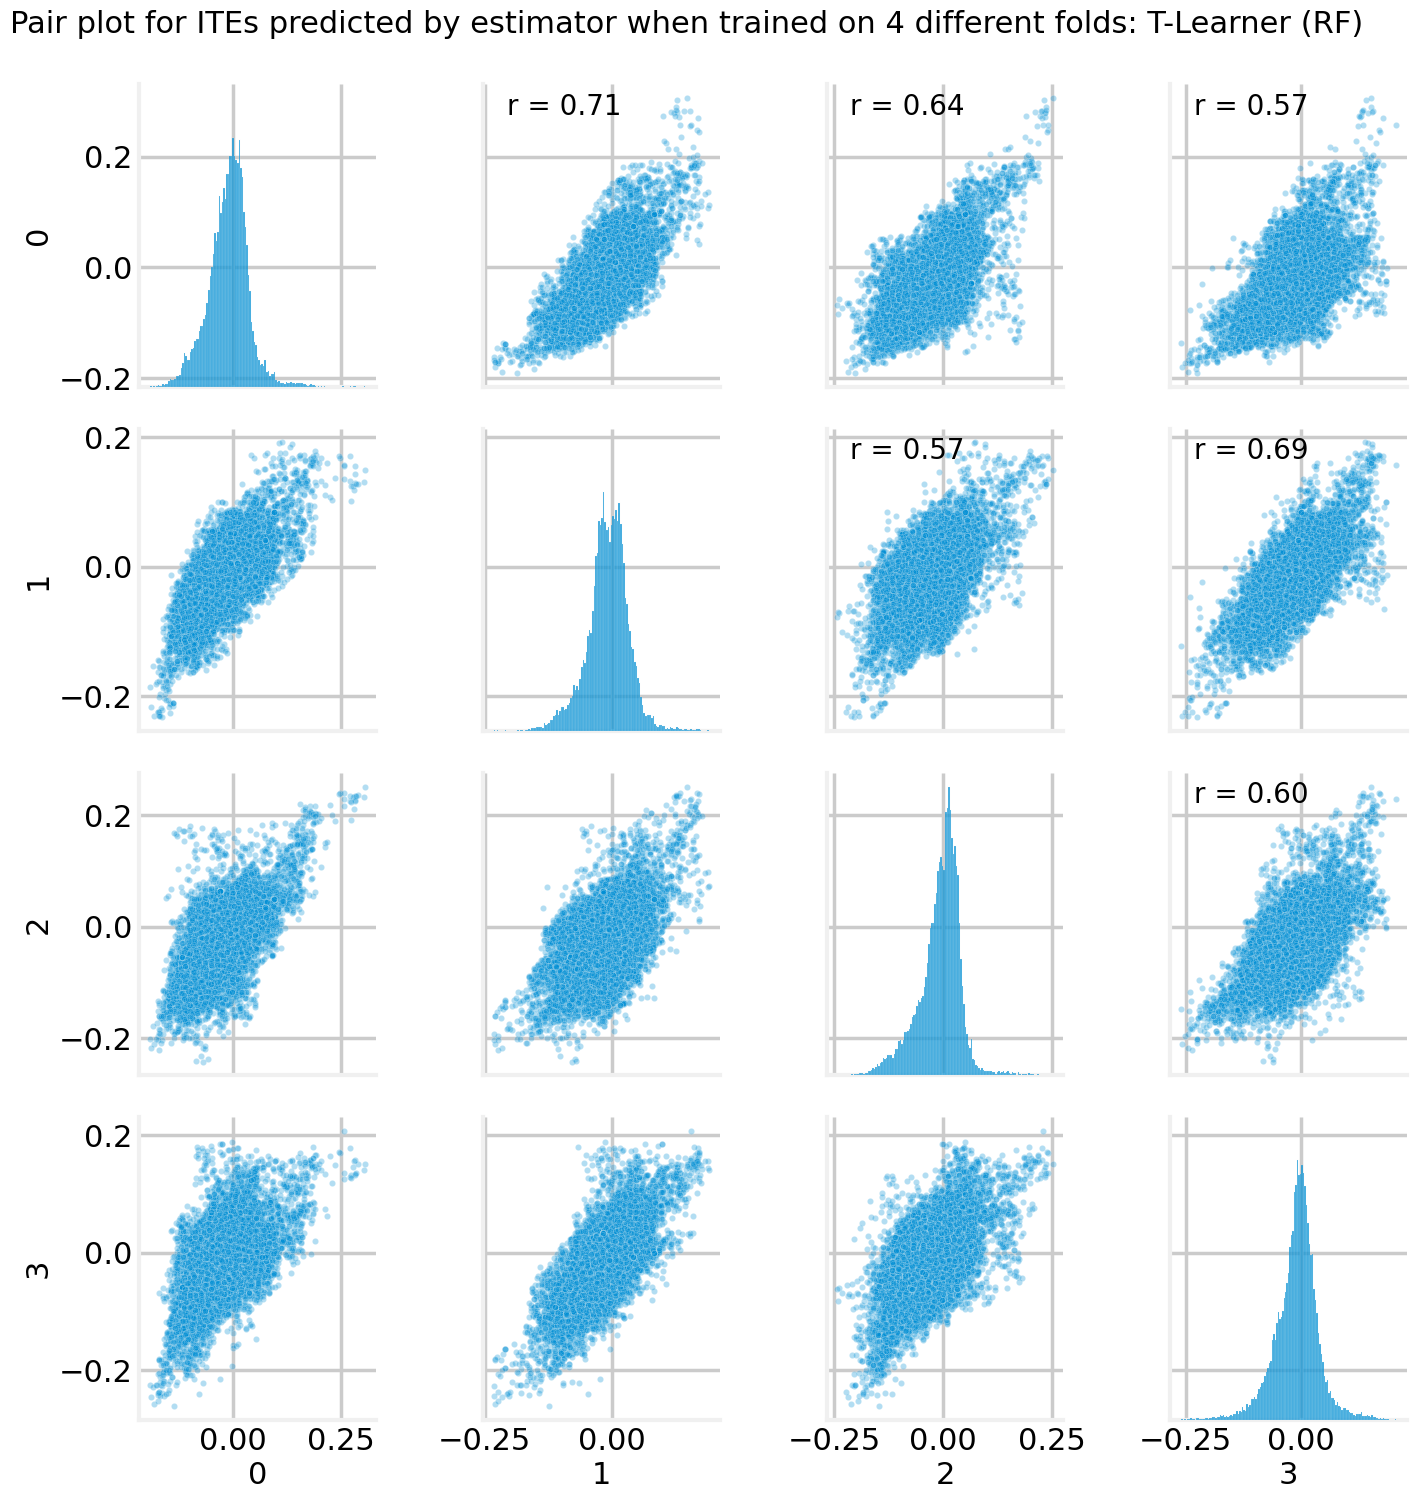

In [44]:
make_model_CATE_pairplot(fitted_libraries["pert_none"]["t_rf"], "T-Learner (RF)")

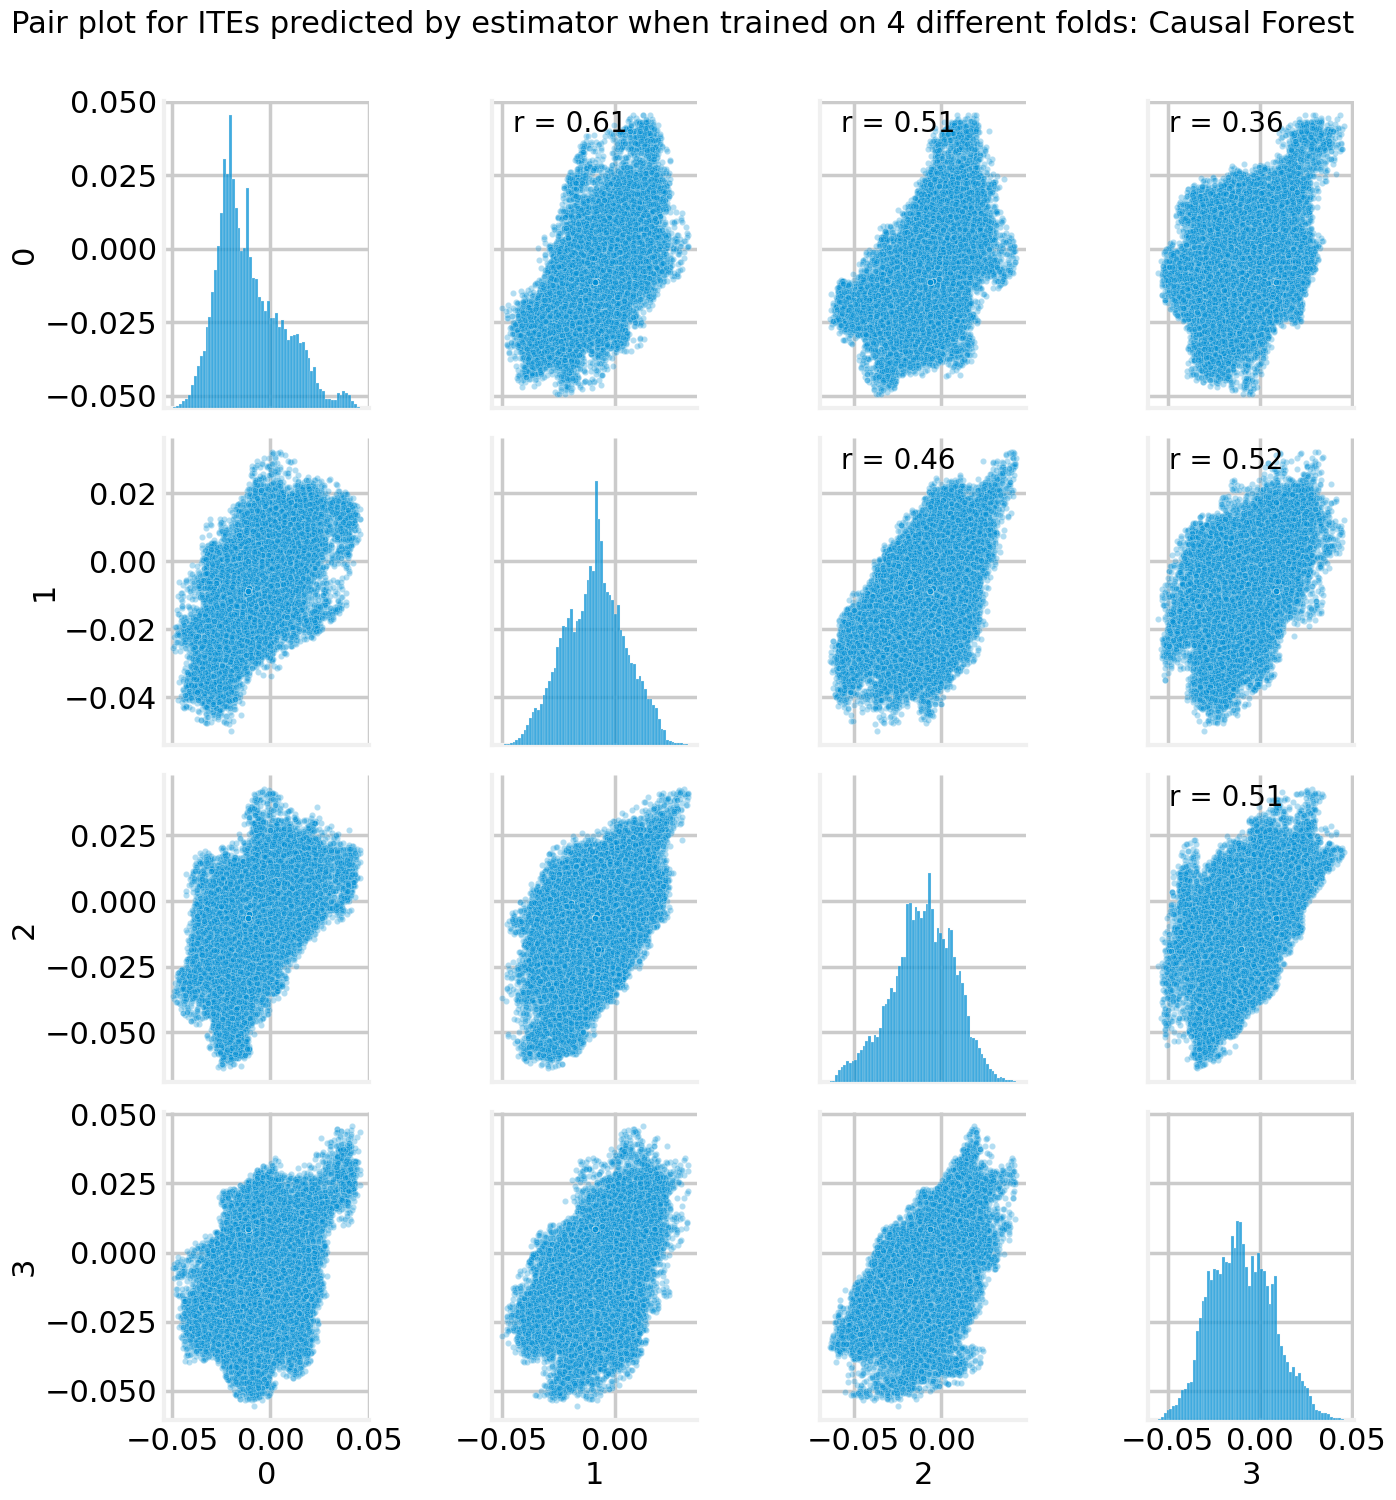

In [45]:
make_model_CATE_pairplot(fitted_libraries["pert_none"]["causal_forest_1"], "Causal Forest")